In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ctl

from utils import BandFilter, Integral, LowBandFilter, NumpyFilter

# IMPORTANDO DADOS

In [5]:
df = pd.read_csv('DataBase.csv')
df

,time,vy,px,py,pz,pitch,roll,yaw,wz,vz,wx,wy,ax,ay,az,vx
0,3.320,0.021948,0.019990,-0.020469,0.009984,-0.057905,-0.114840,0.798700,2.474524,0.000895,-0.322430,-0.277089,0.061274,-0.046212,0.178531,0.031246
1,3.380,-0.000528,0.026251,-0.018599,0.013175,-0.055575,-0.139723,0.942146,2.335546,0.039332,-0.288101,-0.297452,0.283355,-0.229186,0.074585,0.062940
2,3.400,-0.003420,0.029103,-0.018698,0.014985,-0.054413,-0.148056,0.987917,2.266046,0.033100,-0.284702,-0.308984,-0.755332,0.113509,-0.323889,0.051141
3,3.420,-0.000526,0.030702,-0.018797,0.016135,-0.052614,-0.156462,1.033017,2.232911,0.012886,-0.299299,-0.307795,-0.777782,0.002254,-0.484672,0.012813
4,3.440,0.012144,0.030466,-0.018506,0.016619,-0.049868,-0.164871,1.078760,2.265946,0.006477,-0.326377,-0.297915,-0.624772,0.504547,0.228321,-0.022251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2103,46.814,0.113258,14.905250,-8.873163,-35.069840,-0.864452,-1.711663,-1.619682,1.588570,-0.263565,-1.514655,0.388784,-0.006540,-0.019308,-0.002785,0.388290
2104,46.834,0.113116,14.924670,-8.867504,-35.083020,-0.894970,-1.722489,-1.579578,1.588185,-0.263585,-1.515608,0.388951,0.019887,0.013614,0.001974,0.388624
2105,46.854,0.113190,14.944100,-8.861847,-35.096200,-0.925197,-1.735784,-1.537352,1.586532,-0.263504,-1.516578,0.389382,-0.015730,-0.010640,0.001261,0.388728
2106,46.874,0.113594,14.963530,-8.856177,-35.109380,-0.955050,-1.751853,-1.492673,1.585089,-0.263555,-1.517009,0.389928,-0.004023,0.026798,-0.003306,0.388234


# NORMALIZANDO DADOS

In [6]:
print(float(np.round(df.time.diff().median(), 3)))
dt = 0.020

0.02


In [7]:
def normalizeTable(df, key, dt=0.15):
    df[key]  = df[key] - df[key][0] # INICIA NO TEMPO 0
    initTime = df[key].iloc[0]
    finalTime = df[key].iloc[-1] + dt
    newAxis = np.arange(initTime, finalTime, dt)
    df = df.set_index(key).reindex(newAxis, method='ffill')
    return df.reset_index().rename(columns={'index': key})


df = normalizeTable(df, 'time', dt)
df.head()

,time,vy,px,py,pz,pitch,roll,yaw,wz,vz,wx,wy,ax,ay,az,vx
0,0.00,0.021948,0.019990,-0.020469,0.009984,-0.057905,-0.114840,0.798700,2.474524,0.000895,-0.322430,-0.277089,0.061274,-0.046212,0.178531,0.031246
1,0.02,0.021948,0.019990,-0.020469,0.009984,-0.057905,-0.114840,0.798700,2.474524,0.000895,-0.322430,-0.277089,0.061274,-0.046212,0.178531,0.031246
2,0.04,0.021948,0.019990,-0.020469,0.009984,-0.057905,-0.114840,0.798700,2.474524,0.000895,-0.322430,-0.277089,0.061274,-0.046212,0.178531,0.031246
3,0.06,0.021948,0.019990,-0.020469,0.009984,-0.057905,-0.114840,0.798700,2.474524,0.000895,-0.322430,-0.277089,0.061274,-0.046212,0.178531,0.031246
4,0.08,-0.000528,0.026251,-0.018599,0.013175,-0.055575,-0.139723,0.942146,2.335546,0.039332,-0.288101,-0.297452,0.283355,-0.229186,0.074585,0.062940


# CONVERSÃO DE UNIDADES
Os sensores entregam dados em unidades digitais (LSB), que precisam ser convertidas para m/s² (aceleração) e rad/s (velocidade angular) para fazer cálculos físicos corretos, como integração e rotação.

In [8]:
def converScales(df):
    # Acelerômetro: ±2g → 16384 LSB/g, g = 9.81 m/s²
    df['ax'] = (df['ax'] / 16384.0) * 9.81
    df['ay'] = (df['ay'] / 16384.0) * 9.81
    df['az'] = (df['az'] / 16384.0) * 9.81

    # Giroscópio: ±250°/s → 131 LSB/(°/s), converter para rad/s
    df['wx'] = (df['wx'] / 131.0) * (np.pi / 180)
    df['wy'] = (df['wy'] / 131.0) * (np.pi / 180)
    df['wz'] = (df['wz'] / 131.0) * (np.pi / 180)
    df.head()
    return

#df = converScales(df)

# VETORIZAÇÃO

In [9]:
aData = np.array([[ax, ay, az] for (ax, ay, az) in zip(df.ax, df.ay, df.az)])
wData = np.array([[ax, ay, az] for (ax, ay, az) in zip(df.wx, df.wy, df.wz)])
tData = df.time.to_numpy()
aData[:5]

array([[ 0.06127436, -0.04621218,  0.1785311 ],
       [ 0.06127436, -0.04621218,  0.1785311 ],
       [ 0.06127436, -0.04621218,  0.1785311 ],
       [ 0.06127436, -0.04621218,  0.1785311 ],
       [ 0.2833552 , -0.2291857 ,  0.07458487]])

# POSIÇÃO
$a = \frac{dv}{dt}$

$v = \int_0^t a(t)\, dt$, mas $v = \frac{dx}{dt}$

$\frac{dx}{dt} = \int_0^t a(t)\, dt$

$x = \int_0^t \int_0^t a(t)\, dt\, dt$

In [10]:
def plotData(time, data):
    keys, values = list(data.keys()), list(data.values())
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.plot(time, values[0])
    plt.xlabel('time'), plt.ylabel('value')
    plt.title(rf'${keys[0]}$')
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.plot(time, values[1])
    plt.xlabel('time'), plt.ylabel('value')
    plt.title(rf'${keys[1]}$')
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(time, values[2])
    plt.xlabel('time'), plt.ylabel('value')
    plt.title(rf'${keys[2]}$')
    plt.grid()

### Aceleração Linear

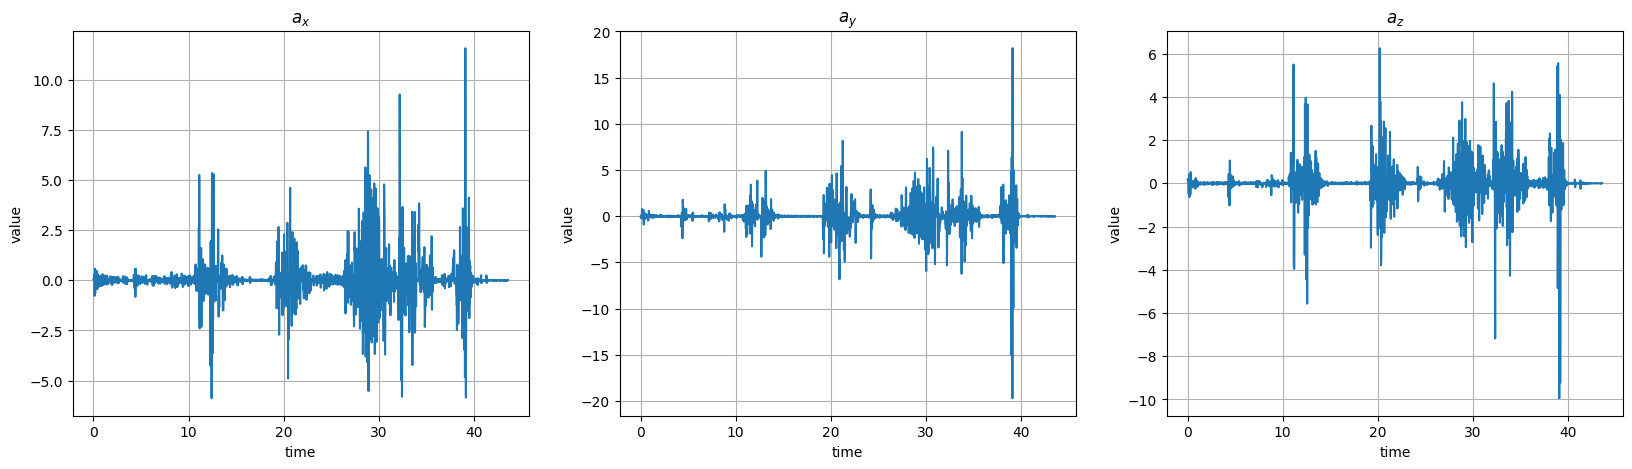

In [11]:
plotData(tData, {
    'a_x': [ax for (ax, ay, az) in aData],
    'a_y': [ay for (ax, ay, az) in aData],
    'a_z': [az for (ax, ay, az) in aData],
})

- Aplicando Filtro Passa Faixa

TransferFunction(array([6.28318531, 0.        ]), array([ 1.        ,  6.28318531, 29.6088132 ]))

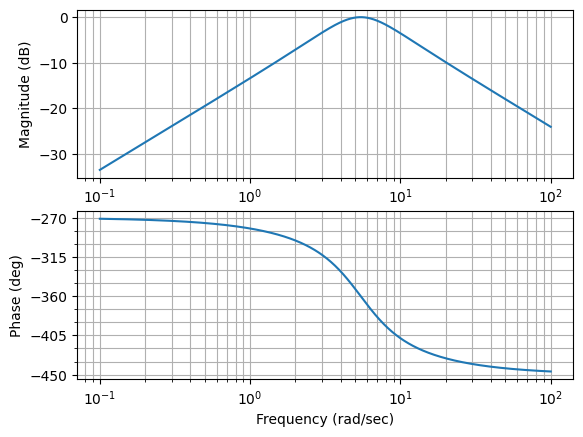

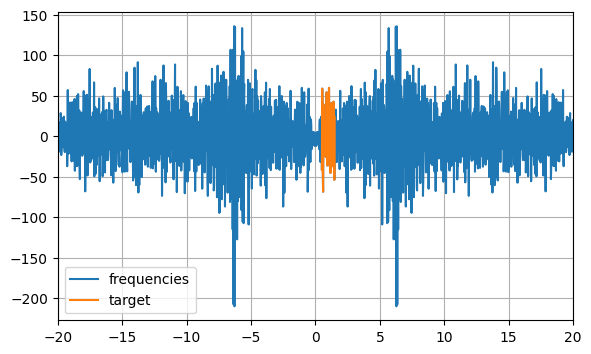

In [12]:
target = (0.5, 1.5)
filter = BandFilter(dt, target)
filter.plot()
NumpyFilter().see([ax for (ax, ay, az) in aData], dt, target, range=(-20, 20))

In [13]:
print(filter.getOut() + ';')

Xn*(0.058953) + Xn1*(0.000000) + Xn2*(-0.058953) + Yn1*(1.870981) + Yn2*(-0.882094);


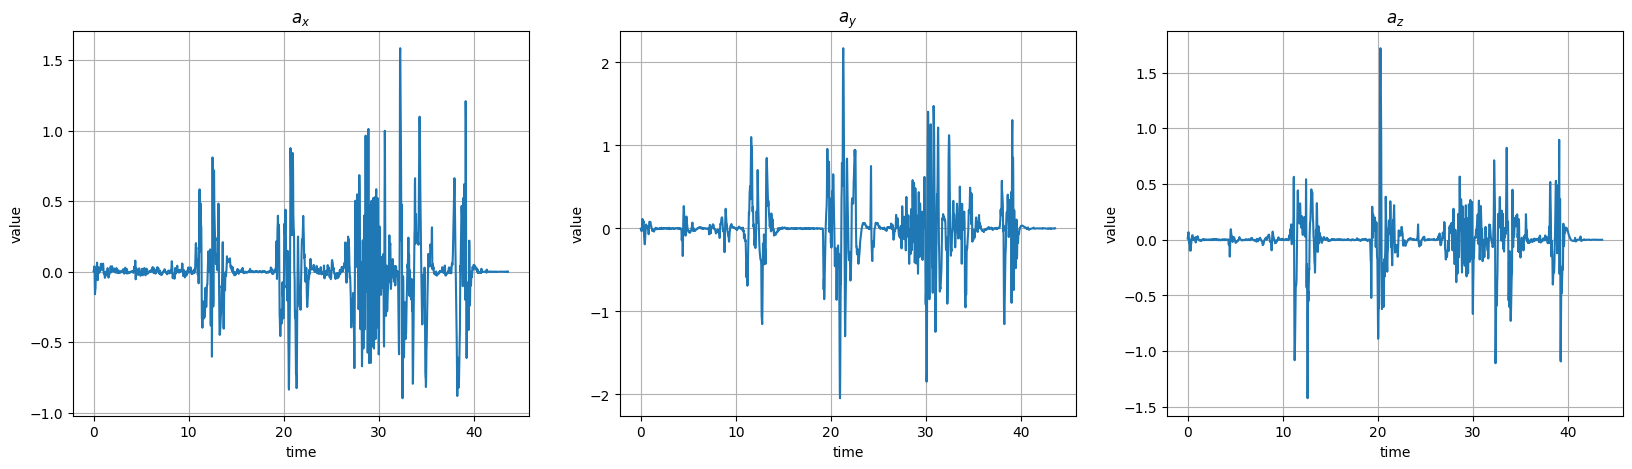

In [14]:
aData = np.column_stack([
    filter.apply([ax for (ax, ay, az) in aData]),
    filter.apply([ay for (ax, ay, az) in aData]),
    filter.apply([az for (ax, ay, az) in aData])
])

plotData(tData, {
    'a_x': [ax for (ax, ay, az) in aData],
    'a_y': [ay for (ax, ay, az) in aData],
    'a_z': [az for (ax, ay, az) in aData],
})

### Velocidade Linear

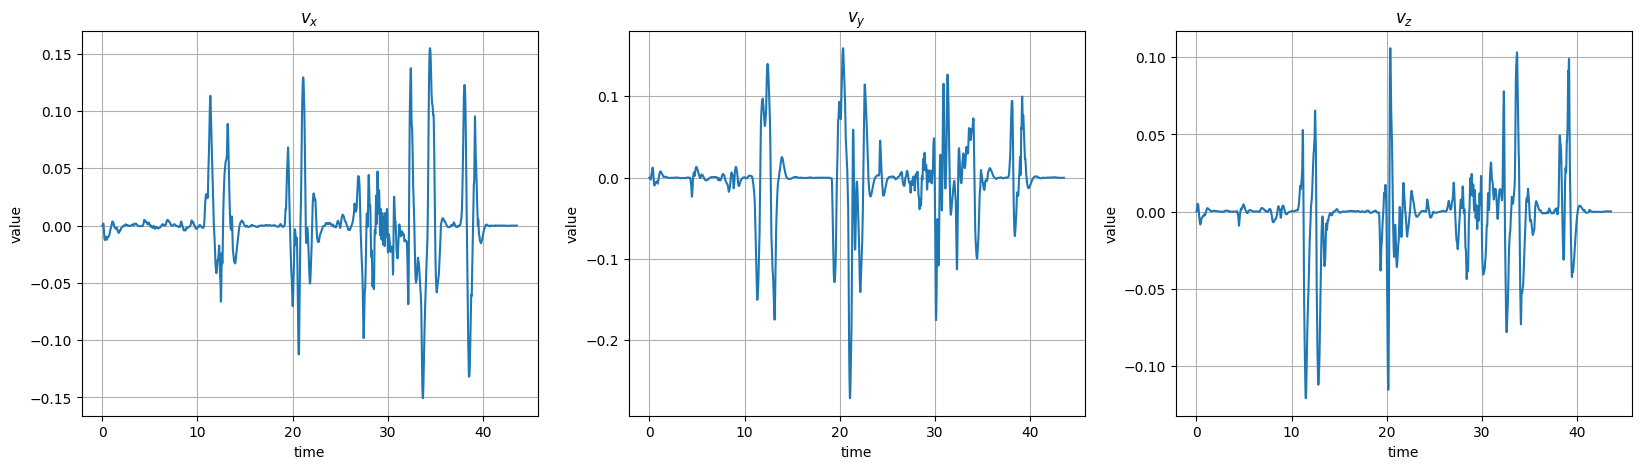

In [15]:
vData = np.column_stack([
    Integral(dt).apply([ax for (ax, ay, az) in aData]),
    Integral(dt).apply([ay for (ax, ay, az) in aData]),
    Integral(dt).apply([az for (ax, ay, az) in aData])
])

plotData(tData, {
    'v_x': [vx for (vx, vy, vz) in vData],
    'v_y': [vy for (vx, vy, vz) in vData],
    'v_z': [vz for (vx, vy, vz) in vData],
})

### Posição Linear

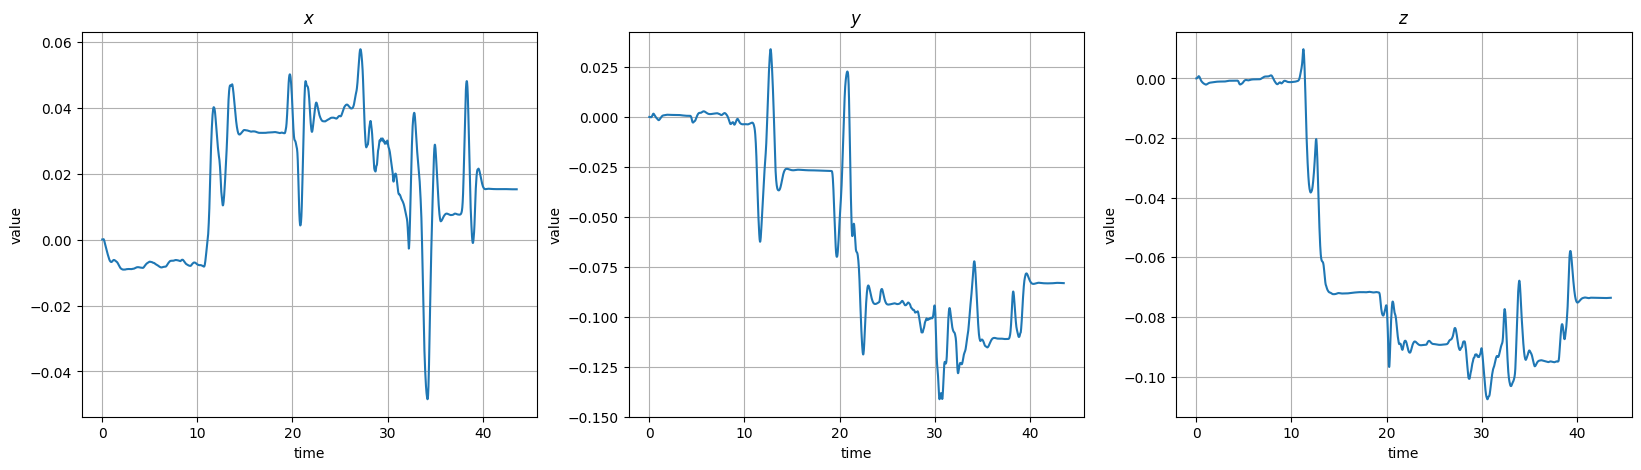

In [16]:
xData = np.column_stack([
    Integral(dt).apply([vx for (vx, vy, vz) in vData]),
    Integral(dt).apply([vy for (vx, vy, vz) in vData]),
    Integral(dt).apply([vz for (vx, vy, vz) in vData])
])

plotData(tData, {
    'x': [x for (x, y, z) in xData],
    'y': [y for (x, y, z) in xData],
    'z': [z for (x, y, z) in xData],
})

TransferFunction(array([157.91367042]), array([  1.        ,  17.77153175, 157.91367042]))

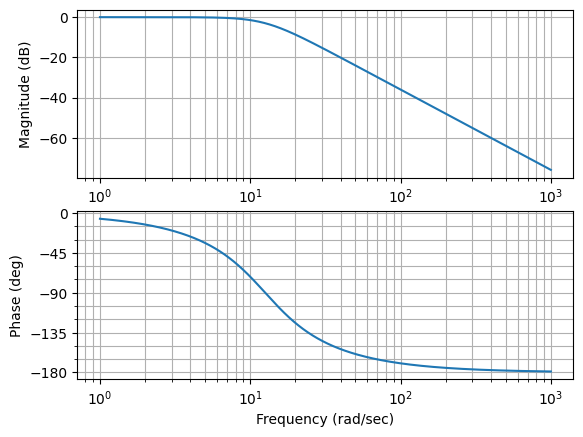

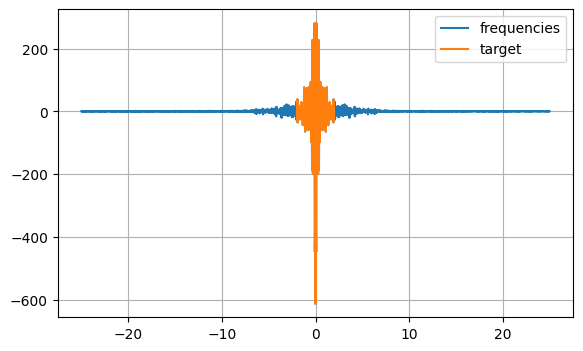

In [17]:
filter = LowBandFilter(f_c=2, dt=dt)
filter.plot()
NumpyFilter().see([wx for (wx, wy, wz) in wData], dt, (-2, 2))

### Angulação

In [18]:
print(filter.getOut() + ';')

Xn*(0.013231) + Xn1*(0.026462) + Xn2*(0.013231) + Yn1*(1.649272) + Yn2*(-0.702196);


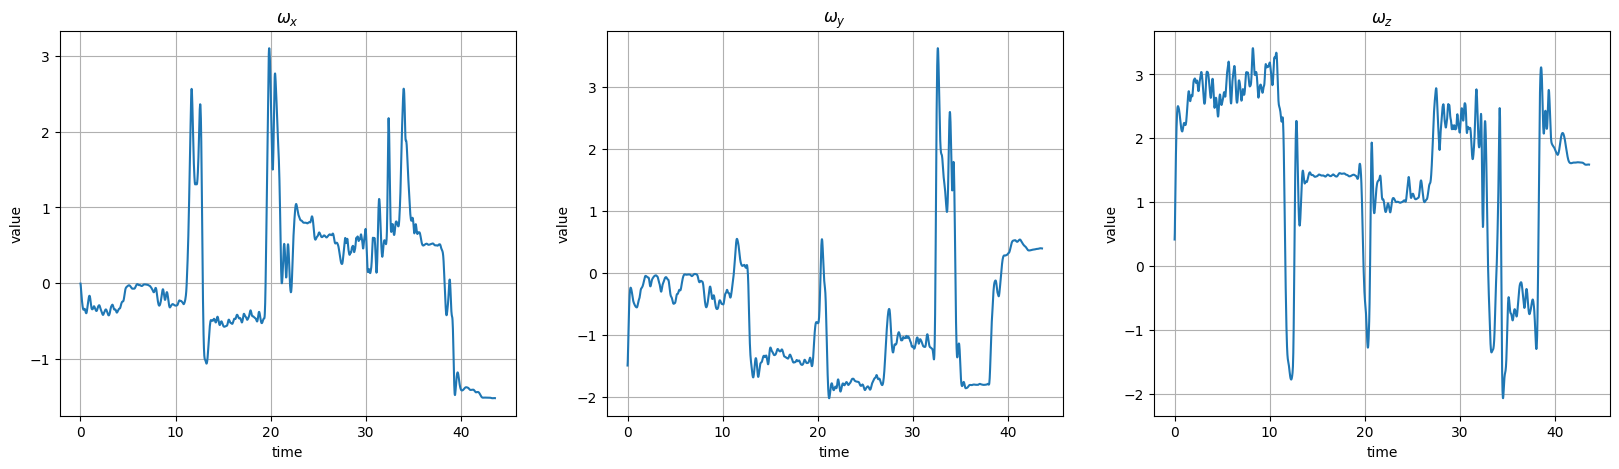

In [19]:
wData = np.column_stack([
    filter.apply([wx for (wx, wy, wz) in wData]),
    filter.apply([wy for (wx, wy, wz) in wData]),
    filter.apply([wz for (wx, wy, wz) in wData])
])

plotData(tData, {
    '\omega_x': [wx for (wx, wy, wz) in wData],
    '\omega_y': [wy for (wx, wy, wz) in wData],
    '\omega_z': [wz for (wx, wy, wz) in wData],
})

### Ângulo

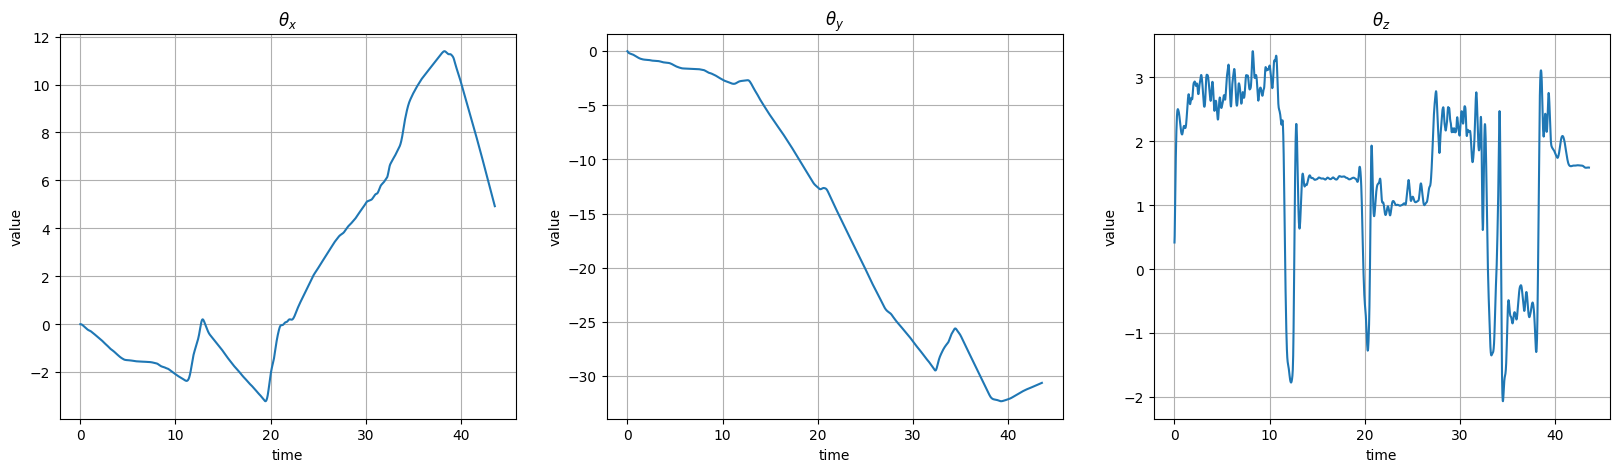

In [20]:
oData = np.column_stack([
    Integral(dt).apply([wx for (wx, wy, wz) in wData]),
    Integral(dt).apply([wy for (wx, wy, wz) in wData]),
    Integral(dt).apply([wz for (wx, wy, wz) in wData])
])

plotData(tData, {
    r'\theta_x': [ox for (ox, oy, oz) in oData],
    r'\theta_y': [oy for (ox, oy, oz) in oData],
    r'\theta_z': [oz for (ox, oy, oz) in wData],
})

### Campo Vetorial

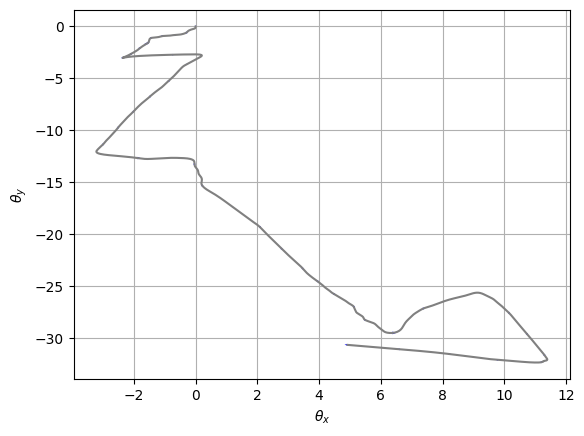

In [21]:
indices = np.linspace(0, len(oData)-1, 40, dtype=int)
x = np.array([ox for (ox, oy, oz) in oData])[indices]
y = np.array([oy for (ox, oy, oz) in oData])[indices]
u = np.array([wx for (wx, wy, wz) in wData])[indices]
v = np.array([wy for (wx, wy, wz) in wData])[indices]

plt.plot([ox for (ox, oy, oz) in oData], [oy for (ox, oy, oz) in oData], color='gray')
plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=15, width=0.004, color='blue')
plt.xlabel(r'$\theta_x$'), plt.ylabel(r'$\theta_y$'), plt.grid()
plt.show()

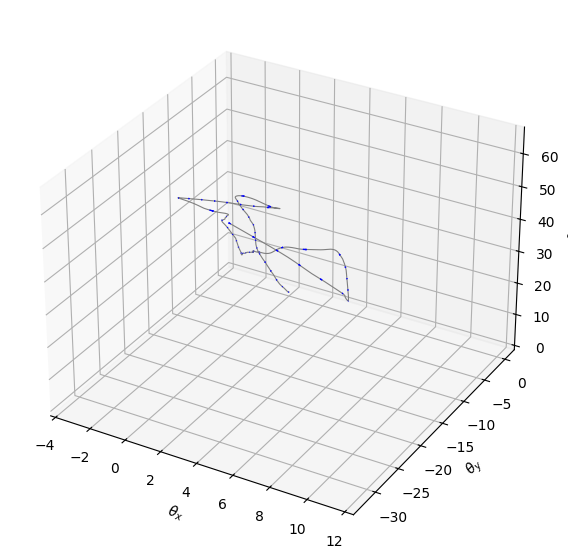

In [22]:
fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(111, projection='3d')
indices = np.linspace(0, len(oData)-1, 50, dtype=int)

x = np.array([ox for (ox, oy, oz) in oData])[indices]
y = np.array([oy for (ox, oy, oz) in oData])[indices]
z = np.array([oz for (ox, oy, oz) in oData])[indices]

u = np.array([wx for (wx, wy, wz) in wData])[indices]
v = np.array([wy for (wx, wy, wz) in wData])[indices]
w = np.array([wz for (wx, wy, wz) in wData])[indices]

plt.plot([ox for (ox, oy, oz) in oData], [oy for (ox, oy, oz) in oData], [oz for (ox, oy, oz) in oData], lw=0.8, color='gray')
ax.quiver(x, y, z, u, v, w, length=0.08, normalize=False, color='blue', linewidth=1)
ax.set_xlabel(r'$\theta_x$'), ax.set_ylabel(r'$\theta_y$'), ax.set_zlabel(r'$\theta_z$')
plt.show()

# ROW, PITCH, YAW

In [23]:
import math

def sign(x):
    return 1 if x >= 0 else -1

class Quaternions:
    def __init__(self):
        self.q = np.array([1.0, 0.0, 0.0, 0.0])
        self.data  = np.array([1.0, 0.0, 0.0, 0.0])
        self.pitch = self.roll = self.yaw = 0

    def product(self, q1, q2):
        w1, x1, y1, z1 = q1.data
        w2, x2, y2, z2 = q2.data

        w = w1*w2 - x1*x2 - y1*y2 - z1*z2
        x = w1*x2 + x1*w2 + y1*z2 - z1*y2
        y = w1*y2 - x1*z2 + y1*w2 + z1*x2
        z = w1*z2 + x1*y2 - y1*x2 + z1*w2
        return np.array([w, x, y, z])
    
    def euler(self, qData):
        q0, q1, q2, q3 = qData.data
        # Roll (x-axis rotation)
        sinr_cosp = 2 * (q0 * q1 + q2 * q3)
        cosr_cosp = 1 - 2 * (q1**2 + q2**2)
        roll = math.atan2(sinr_cosp, cosr_cosp)
        
        # Pich (y-axis rotation)
        sinp  = 2*(q0 * q2 - q3 * q1)
        pitch = sign(sinp)*(math.pi/2) if abs(sinp) >= 1 else math.asin(sinp)

        # Yaw (z-axis rotation)
        siny_cosp = 2 * (q0 * q3 + q1 * q2)
        cosy_cosp = 1 - 2 * (q2**2 + q3**2)
        yaw = math.atan2(siny_cosp, cosy_cosp)
        return (pitch, roll, yaw)

    def fromOmega(self, wx, wy, wz):
        omega = np.array([0.0, wx, wy, wz])
        q_dot = self.product(omega, self.q)
        self.q = q_dot*0.5*dt + self.q
        self.q = self.q / np.linalg.norm(self.q)

    def fromAccel(self, ax, ay, az):
        ax, ay, az = np.array([ax, ay, az]).norm().data
        pitch = math.atan2(-ax, math.sqrt(ay**2 + az**2))
        roll  = math.atan2(ay, az)
        yaw   = 0  # sem magnetômetro

        qroll  = np.array([math.cos(roll/2),  math.sin(roll/2), 0, 0])
        qpitch = np.array([math.cos(pitch/2), 0, math.sin(pitch/2), 0])
        qyaw   = np.array([math.cos(yaw/2),   0, 0, math.sin(yaw/2)])

        #q = q_yaw ⊗ (q_pitch ⊗ q_roll)
        q_temp = self.product(qpitch, qroll)
        return self.product(qyaw, q_temp)
    
    def update(self, ax, ay, az, wx, wy, wz):    
        self.fromOmega(wx, wy, wz)
        #self.fromAccel(ax, ay, az)
        self.pitch, self.roll, self.yaw = self.euler(self.q)


q = Quaternions()

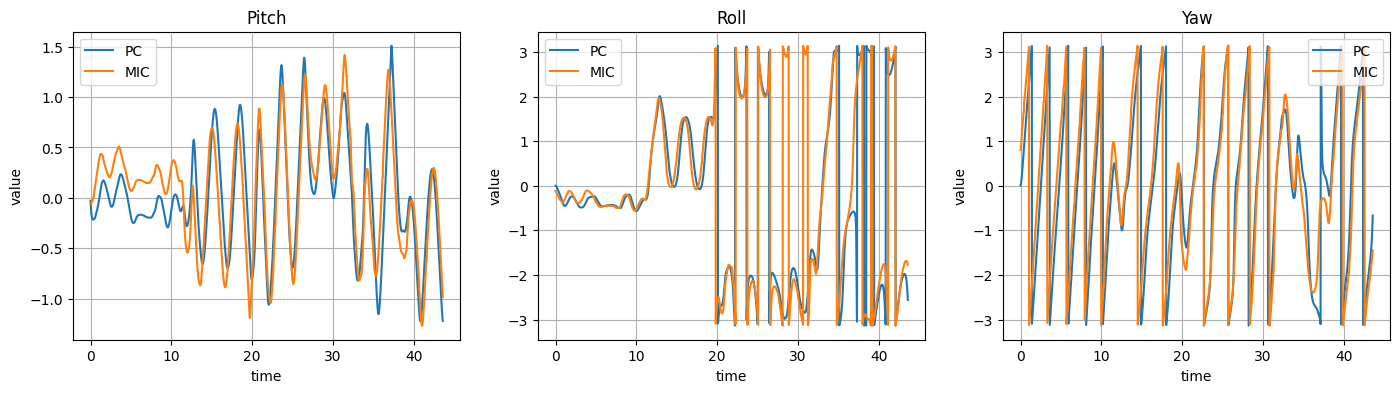

In [24]:
eulerData = []

for a, w in zip(aData, wData):
    ax, ay, az = a 
    wx, wy, wz = w 
    q.update(ax, ay, az, wx, wy, wz)
    eulerData.append([q.pitch, q.roll, q.yaw])

plt.figure(figsize=(17, 4))
plt.subplot(1, 3, 1)
plt.plot(tData, [pitch for (pitch, roll, yaw) in eulerData], label='PC')
plt.plot(df.time, df.pitch, label='MIC')
plt.xlabel('time'), plt.ylabel('value'), plt.legend()
plt.title('Pitch')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(tData, [roll for (pitch, roll, yaw) in eulerData], label='PC')
plt.plot(df.time, df.roll, label='MIC')
plt.xlabel('time'), plt.ylabel('value'), plt.legend()
plt.title('Roll')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(tData, [yaw for (pitch, roll, yaw) in eulerData], label='PC')
plt.plot(df.time, df.yaw, label='MIC')
plt.xlabel('time'), plt.ylabel('value'), plt.legend()
plt.title('Yaw')
plt.grid()